# Utility code

Some utility code for **Introduction to Theoretical Computer Science**

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

In [2]:
GLOBAL_NANDONLY = False

### Parse programs

In [3]:
def parseline(line, numargs = 0):
    """Parse a line of the form foo = 'OP( bar1, bar2, bar3)'
       to ['foo','OP','bar1','bar2','bar2'].
       If numargs > number of arguments in line then add empty strings to the list as needed."""
    i = line.find("=")
    j = line.find("(")
    k = line.find(")")
    if i<0 or j<0 or k<0: raise Exception(f"Line not formatted properly: {line}")
    args = [a.strip() for a in line[j+1:k].split(",")]
    if len(args)<numargs: args += [""]*(numargs-len(args))
    return [line[:i].strip() , line[i+1:j].strip()] + args
        

In [4]:
parseline("foo = NOT( blah)",2)

['foo', 'NOT', 'blah', '']

## Drawing circuits

In [5]:
import graphviz
from graphviz import Graph
from graphviz import Digraph

In [6]:
class Circuit:
    """Class for modelling Boolean Circuits. Allows circuits with arbitrary gates, including rendering and evaluating."""
    
    def __init__(self, n=0):
        self.nodes = {}
        self.in_neighbors = {}
        self.counter = 0
        self.outputs = {}
        self.values = {}
        self.X  = {}
        self.setinputs(n)
    
    def setinputs(self,n):
        """Set number of inputs to n (increases number was smaller than n before, otherwise does nothing.)"""
        for i in range(n): 
            self.nodes[f"input_{i}"] = ("INPUT",i)
            self.X[i] = f"input_{i}"
            self.in_neighbors[f"input_{i}"] = []
        
    
    def gate(self,op,*inputs):
        """Add a new gate."""
        label = f"gate_{self.counter}"
        self.nodes[label] = ("GATE",op)
        self.in_neighbors[label] = inputs
        self.counter += 1
        return label
    
    def output(self,gate,j):
        """Designate a gate as an output gate"""
        self.outputs[gate] = j
    
    def evalnode(self,node,X):
        """Evaluate the value of a node node with respect to a certain input assignment."""
        if node in self.values: return self.values[node]
        if self.nodes[node][0]=="INPUT": 
            val = X[self.nodes[node][1]]
        else:
            val =  self.nodes[node][1](*[self.evalnode(u,X) for u in self.in_neighbors[node]])
        self.values[node] = val
        return val
    
    def __call__(self,*X ,render=False):
        """Evaluate circuit on an input"""
        if isinstance(X, str):
            X = [int(X[i]) for i in range(len(X))]
            
        if len(X) != len(self.X): raise Exception("Mismatched number of inputs.")
        self.values = {}
        Y = {}
        m = 0
        for o,j in self.outputs.items():
            Y[j]= self.evalnode(o,X)
            if j>m: m=j
        if render: schemdraw(C,X)
        if m>1:
            return [Y[j] for j in range(m+1)]
        else:
            return Y[0]
    def size(self):
        return len(self.nodes)-len(self.X)
    
    def draw(self):
        schemdraw(self)
    
    def render_eval(self,*X):
        """Render evaluated circuit on input X"""
        y = self(*X)
        schemdraw(self,X)
        # return self.graph(self.values)

    # def _repr_svg_(self): 
    def _repr_pretty_(self, p, cycle):
        if cycle:
            p.text("---")
        else:
            schemdraw(self)
        return None
        # return self.graph()._repr_svg_()
    
    def opname(self,op):
        names = {"AND":"∧", "OR":"∨", "NOT":"¬", "NAND":"¬∧"}
        if op in names: return names[op]
        return op
    
    def graph(self, vals=None,size="10,5"):
        WIDTH_BASE = 0.5
        """Return representation of circuit as a graph."""
        
        G =  Digraph(graph_attr= {"rankdir":"LR", "size":size,"ratio":"fill"},node_attr={"fixedsize":"true"},strict=False) 
        
        # Start with inputs
        with G.subgraph(name='inputs', graph_attr={'rank':'same'}) as c:
            for (key,node) in self.nodes.items():
                if node[0] == "INPUT":
                    label  = f"X[{node[1]}]"
                    fontcolor='blue'
                    shape = 'circle'
                    width = WIDTH_BASE
                    if vals and key in vals: 
                        label += f"<br/><font color='green' face='monospace'><B>{vals[key]}</B></font>"
                        # width += WIDTH_BASE
                    label = f"< {label} >"
                    c.node(key,label=label,fontcolor=fontcolor, shape=shape,width=f"{width}",orientation="90",fontsize="8")
            
        # Then gates
        for (key,node) in self.nodes.items():
            if node[0] == "INPUT": continue
            label = self.opname(node[1].__name__)
            fontcolor='black'
            shape='invhouse'
            width = WIDTH_BASE
            if key in self.outputs:
                label = f"{label}<font color='red'>→Y[{self.outputs[key]}]</font>"
                width += WIDTH_BASE
            if vals and key in vals: 
                label += f"<br/><font color='green' face='monospace'><B>{vals[key]}</B></font>"
                # width += WIDTH_BASE
            
            label = f"<{label}>"
                
            G.node(key,label=label,fontcolor=fontcolor ,width=f"{width}",shape=shape,orientation="90",fontsize="8")
            for v in self.in_neighbors[key]:
                G.edge(v,key)
            
        return G

## Schemdraw attempt

```    
    xy     : [x,y] starting coordiante.
             Element drawn in current direction and default length.
    endpts : [[x1,y1], [x2,y2]] start and end coordinates
    to     : [x,y] end coordinate
    tox    : x-value of end coordinate (y-value same as start)
    toy    : y-value of end coordinate (x-value same as start)
    l      : total length of element
    zoom   : zoom/magnification for element (default=1)
    anchor : 'xy' argument refers to this position within the element.
             For example, an opamp can be anchored to 'in1', 'in2', or 'out'
```

In [7]:
# Use schemdraw to visualize circuits
import SchemDraw as schem
import SchemDraw.elements as e
import SchemDraw.logic as l

In [8]:
import re

def getpositions(self):
    G = self.graph()
    text = G.pipe(format="plain").decode("utf-8")
    positions = {}
    for (key,node) in self.nodes.items():
        m =  re.search(rf"node {key} ([\d]+(?:\.[\d]+)?) ([\d]+(?:\.[\d]+)?)",text)
        positions[key]= (float(m.group(1)),float(m.group(2)))
    return positions

In [9]:
import math
def schemdraw(self, myvals=None, filename = ""):
        """Visualize using Schemdraw."""
        MAXY = 30
        INC  = 2.5
        positions = getpositions(self)
        for key in positions:
            positions[key] = (positions[key][0]*1.2,positions[key][1]*1.5)
        vals = None
        if myvals:
            self(*myvals)
            vals = self.values
            
        G = schem.Drawing(unit=.5,inches_per_unit = 0.2*9/math.sqrt(self.size()), fontsize=8)
        elements = {}
        gates = {"AND": l.AND2, "OR": l.OR2, "NAND": l.NAND2, "NOT": l.NOT }
        
        curx = 0
        cury = MAXY
        # Start with inputs
        for (key,node) in self.nodes.items():
            if node[0] == "INPUT":
                label  = f"$X[{node[1]}]$"
                botlabel = ""
                if vals and key in vals: 
                    botlabel += f" ({vals[key]})"
                curx,cury = positions[key]
                v = G.add(e.DOT, xy = [curx,cury],label=label,botlabel=botlabel)
                elements[key]= [curx,cury]
                cury -= INC
            
        cury = MAXY + INC/2
        curx = INC
            
        # Then gates
        for (key,node) in self.nodes.items():
            if node[0] == "INPUT": continue
            op = gates[node[1].__name__]
            label = ""
            rgtlabel = ""
            if key in self.outputs:
                rgtlabel = f"$Y[{self.outputs[key]}]$"
            botlabel = ""
            if vals and key in vals: 
                botlabel = f" ({vals[key]})"
            
            cury -= INC
            maxx = max([elements[n][0] for n  in self.in_neighbors[key]])
            if curx < maxx + INC:
                curx = maxx + INC
                cury = MAXY
                if round(curx / INC) % 2:
                    cury -= INC / 2
       
            if cury< 0:
                cury = MAXY
                curx += INC
                if round(curx / INC) % 2:
                    cury -= INC / 2
       
            curx,cury = positions[key]
            v = G.add(op,xy =[curx,cury], label=label, botlabel = botlabel, rgtlabel =rgtlabel, d="right")
            elements[key] = v.out if op != l.NOT else [curx+1.35,cury]
            L =  self.in_neighbors[key]
            if len(L)==1:
                G.add(e.LINE,xy= elements[L[0]] ,to=[curx,cury])
            if len(L)==2:
                pos1 = elements[L[0]]
                pos2 = elements[L[1]]
                if pos1[1] < pos2[1]:
                    pos1,pos2 = pos2,pos1
                G.add(e.LINE,xy = pos1 ,to = v.in1)
                G.add(e.LINE,xy = pos2 ,to = v.in2)
        width = min(9,3+self.size()*0.3)
        G.inches_per_unit = width/curx
        G.draw()
        if filename:
            G.save(filename)
        return None

In [10]:
def NAND(a,b): return 1 - a*b

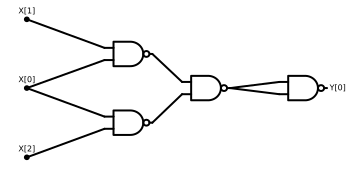

In [11]:
C = Circuit(3)
g = C.gate(NAND,C.X[0],C.X[1])
h = C.gate(NAND,C.X[0],C.X[2])
z = C.gate(NAND,g,h)
y = C.gate(NAND,z,z)
C.output(y,0)
C

0

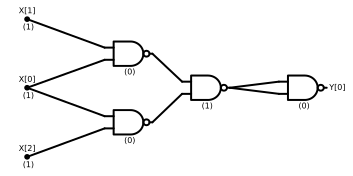

In [12]:
C(1,1,1 , render=True)

In [13]:
import re
def numinout(prog):
    '''Compute the number of inputs and outputs of a NAND program, given as a string of source code.'''
    n = max([int(s[2:-1]) for s in re.findall(r'X\[\d+\]',prog)])+1
    m = max([int(s[2:-1]) for s in re.findall(r'Y\[\d+\]',prog)])+1
    return n,m

In [14]:
def prog2circuit(code,gateset=None):
    """Transform a straightline program into a circuit.
       Takes as input the basic gates one uses (otherwise use all functions currently defined)"""
    if not gateset: gateset = globals()
    n,m = numinout(code) # helper function - extract number of inputs and outputs from code
    C = Circuit(n) # create circuit with n inputs 
    
    nodes = { f"X[{i}]" : C.X[i] for i in range(n) }
    # initially we have n nodes corresponding to n inputs.
    
    for line in code.split("\n"): # every line is translated to a new gate
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        # parseline takes "foo = OP(bar,blah)" to the list ["foo","OP","bar","blah"]
        if blah: g = C.gate(gateset[op],nodes[bar],nodes[blah])
        else: g = C.gate(gateset[op],nodes[bar])
        nodes[foo] = g
        if foo[0]=="Y": C.output(g,int(foo[2:-1]))
    
    return C
    

In [15]:
def circuit2prog(C):
    """Transform circuit to a program."""
    
    code = ""
    def key2var(key):
        """Helper function: translate  key identifying a node into a variable name"""
        if key[:6]=="input_": return f"X[{key[6:]}]"
        elif key in C.outputs: return f"Y[{C.outputs[key]}]"
        return key

    # every gate is translated into a line
    for (key,n) in C.nodes.items(): 
        # we assume nodes are in topological ordering, otherwise  should layer first
        if n[0]!="GATE": continue  # ignore input (non gate) nodes
        args = ",".join(map(key2var,C.in_neighbors[key]))
        code += f"{key2var(key)} = {n[1].__name__}({args})\n"
    
    return code

In [16]:
print(circuit2prog(C))

gate_0 = NAND(X[0],X[1])
gate_1 = NAND(X[0],X[2])
gate_2 = NAND(gate_0,gate_1)
Y[0] = NAND(gate_2,gate_2)



In [17]:
prog = r"""
temp = NAND(X[0],X[1])
Y[0] = NAND(temp,temp)"""[1:]


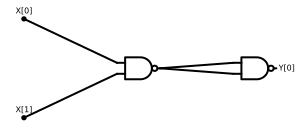

In [18]:
prog2circuit(prog)

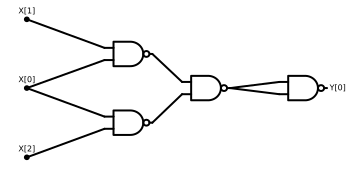

In [19]:
C

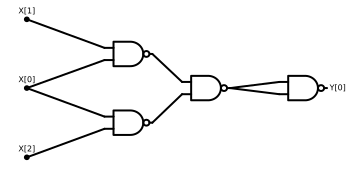

In [20]:
schemdraw(C)

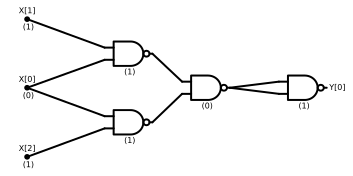

In [21]:
schemdraw(C,[0,1,1])

## Extract code from python function

In [22]:
def AND(a,b):
    return a*b
def OR(a,b):
    return 1-(1-a)*(1-b)
def NOT(a):
    return 1-a
def NAND(a,b):
    return 1-a*b

In [23]:
from inspect import signature
def function2code(f,*inlens, NANDONLY = False):
    """Take python function that ultimately is implemented using AND/OR/NOT/NAND
    and output the code for it using these operations"""
    explode = False
    if not inlens:
        explode = True
        n = len(signature(f).parameters)
        X = [f"X[{i}]" for i in range(n)]
    else:
        n = sum(inlens) 
        X = []
        i = 0
        for ell in inlens:
            X.append([f"X[{i+j}]" for j in range(ell)])
            i += ell

    counter = 0
    code = ""
    def getvar():
        nonlocal counter
        counter +=1
        return f"temp_{counter}"
    def op(name,a,b=None): 
        nonlocal code
        v = getvar()
        if b: 
            code += f"\n{v} = {name}({a},{b})"
        else:
            code += f"\n{v} = {name}({a})"
        return v
    
    def AND_(a,b):
        return NAND(NAND(a,b),NAND(a,b))
    def OR_(a,b):
        return NAND(NAND(a,a),NAND(b,b))
    
    def NOT_(a):
        return NAND(a,a)

    global AND
    global OR
    global NOT
    global NAND
    _ = AND
    __ = OR
    ___ = NOT
    ____ = NAND
    try:
        NAND = lambda a,b: op("NAND",a,b)
        if NANDONLY or GLOBAL_NANDONLY:
            AND = AND_
            OR  = OR_
            NOT = NOT_
        else:
            AND = lambda a,b: op("AND",a,b)
            OR = lambda a,b: op("OR",a,b)
            NOT = lambda a: op("NOT",a)
        
        v= f(*X)
    finally:
        AND = _ 
        OR  = __ 
        NOT = ___
        NAND = ____
    if type(v) is list or type(v) is tuple:
        for i in range(len(v)):
            code = code.replace(v[i]+" ",f"Y[{i}] ")
    else:
        code = code.replace(v,"Y[0]")
    return code


In [24]:
def drawcirc(f,*inlens,NANDONLY=False):
    if not inlens:
        code = function2code(f,NANDONLY=NANDONLY)
    else:
        code = function2code(f,*inlens,NANDONLY=NANDONLY)
    C = prog2circuit(code)
    schemdraw(C)

In [25]:
def XOR3(a,b,c):
    w1 = AND(a,b)
    w2 = NOT(w1)
    w3 = OR(a,b)
    w4 = AND(w2,w3)
    w5 = AND(w4,c)
    w6 = NOT(w5)
    w7 = OR(w4,c)
    return AND(w6,w7)


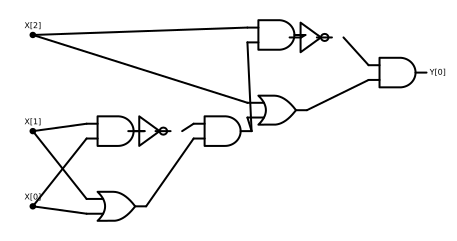

In [26]:
drawcirc(XOR3)

In [27]:
def circuit(code,*inlens, NANDONLY=False):
    if isinstance(code, str):
        C = prog2circuit(code)
        return C
    elif callable(code):
        if not inlens:
            newcode = function2code(code,NANDONLY=NANDONLY)
        else:
            newcode = function2code(code,*inlens,NANDONLY=NANDONLY)
        return prog2circuit(newcode)

_Input_ | _Output_
--------|---------
  $00$  | $1$
  $01$  | $0$

## Nice printing

In [28]:
from IPython.display import Markdown, display

def htmlspace(s):
    return s.replace(" ","&nbsp;")

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string) if color else string
    display(Markdown(colorstr))
    
def color(c,s,j=0):
    return "<span style='color:{}'>{}</span>".format(c, s.ljust(j))
    
def bold(s,justify=0):
    return "<B>"+s.ljust(justify)+"</B>"
#  return "\x1b[1m"+s.ljust(justify)+"\x1b[0m"

#def underline(s,justify=0):
#    return "\x1b[4m"+s.ljust(justify)+"\x1b[24m"

def red(s,justify=0):
    return color("red",s,justify)  #.replace(" ","&nbsp;")
    #return  "\x1b[31m"+s.ljust(justify)+"\x1b[0m"


def green(s,justify=0):
    return color("green",s,justify) #.replace(" ","&nbsp;")
    # return  "\x1b[32m"+s.ljust(justify)+"\x1b[0m"


def blue(s,justify=0):
    return color("blue",s,justify) #.replace(" ","&nbsp;")
    # return  "\x1b[34m"+s.ljust(justify)+"\x1b[0m"

In [29]:
def mdtable(L,header=True):
    l = max(max([len(str(a)) for a in A]) for A in L)
    n = len(L[0])
    res = ""
    sep = "|".join(["-"*(l+1) for i in range(n)])+"\n"
    for A in L:
        res += " | ".join([bold(str(s),l) if header else str(s).ljust(l) for s in A])+"\n"
        if header:
            res += sep
            header = False
    return Markdown(res)

L = [["col one", "col 2", "col 3"],[2, 18, 19], [4, 20, 23]]
mdtable(L)

<B>col one</B> | <B>col 2  </B> | <B>col 3  </B>
--------|--------|--------
2       | 18      | 19     
4       | 20      | 23     


In [30]:
from IPython.display import display, Markdown, Latex
import itertools

def table(C, n=0):
        if isinstance(C,str):
            C= circuit(C)
        if not callable(C):
            raise ValueError(f"{C} is not callable")
        if not n:
            if isinstance(C,Circuit):
                n = len(C.X)
            else:
                n = len(signature(C).parameters)
        res = r"""_Input_ | _Output_
--------|---------
"""
        for X in itertools.product((0,1),repeat=n):
            x = "".join([str(b) for b in X])
            output = C(*X)
            if isinstance(output,(list,tuple)):
                y = "".join([str(a) for a in output])
            else:
                y = str(output)
            res += f"  ${x}$  | ${y}$ \n"
        
        display(Markdown(res))


In [31]:
def XOR(a,b):
    u = NAND(a,b)
    v = NAND(a,u)
    w = NAND(b,u)
    return NAND(v,w)

table(XOR)

_Input_ | _Output_
--------|---------
  $00$  | $0$ 
  $01$  | $1$ 
  $10$  | $1$ 
  $11$  | $0$ 


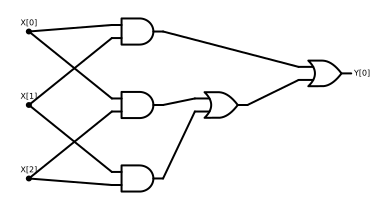

In [32]:
majcode = r"""firstpair  = AND(X[0],X[1])
secondpair = AND(X[1],X[2])
thirdpair  = AND(X[0],X[2])
temp       = OR(secondpair,thirdpair)
Y[0] =  OR(firstpair,temp)
"""
C = circuit(majcode)
C

In [33]:
table(C)

_Input_ | _Output_
--------|---------
  $000$  | $0$ 
  $001$  | $0$ 
  $010$  | $0$ 
  $011$  | $1$ 
  $100$  | $0$ 
  $101$  | $1$ 
  $110$  | $1$ 
  $111$  | $1$ 


In [34]:
def ADD1(a,b):
    return AND(a,b),XOR(a,b)

table(ADD1)

_Input_ | _Output_
--------|---------
  $00$  | $00$ 
  $01$  | $01$ 
  $10$  | $01$ 
  $11$  | $10$ 


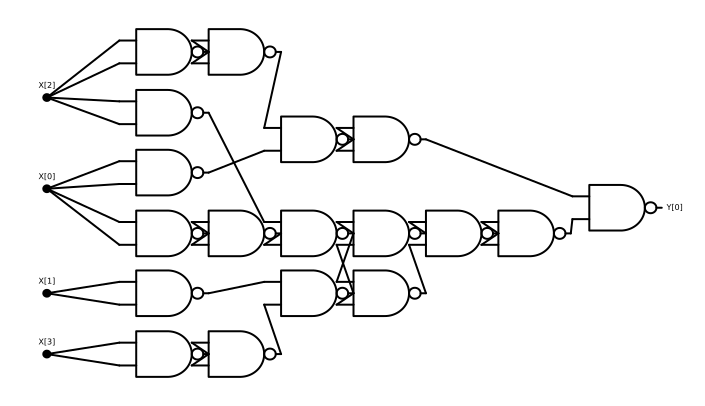

In [35]:
def BIG1(a,b):
    t = NOT(b)
    return OR(a,t)

def BIG2(X):
    """Input is X[0]...X[3] which we consider as two three-bit numbers A and B. We return 1 iff A>B"""
    y1 = BIG1(X[0],X[2])
    n1 = BIG1(X[2],X[0])
    y2 = BIG1(X[1],X[3])
    t  = AND(y2,n1)
    return OR(y1,t)

circuit(BIG2,4, NANDONLY = True)

In [36]:
def MAJ(a,b,c):
    return NAND(NAND(NAND(NAND(a,b),NAND(a,c)),NAND(NAND(a,b),NAND(a,c))),NAND(b,c))

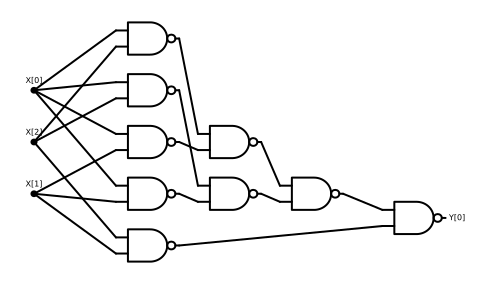

In [37]:
circuit(MAJ)

## Some random stuff

In [38]:
def subscriptdigit(d):
    return ["₀","₁","₂","₃","₄","₅","₆","₇","₈","₉"][d]

def subscript(s):
    digits = ["0","1","2","3","4","5","6","7","8","9"]
    return "".join([subscriptdigit(int(s[i])) if s[i] in digits else s[i] for i in range(len(s))])

In [39]:
def scale(G,sizeparam="10,5"):
    G.graph_attr.update(size=sizeparam, ratio="fill")
    return G

In [40]:
def parseline(line, numargs = 2):
    """Parse a line of the form foo = 'OP( bar1, bar2, bar3)'
       to ['foo','OP','bar1','bar2','bar2'].
       If numargs > number of arguments in line then add empty strings to the list as needed."""
    if not line: return [""]*(2+numargs)
    i = line.find("=")
    j = line.find("(")
    k = line.find(")")
    if i<0 or j<0 or k<0: raise Exception(f"Line not formatted properly: {line}")
    args = [a.strip() for a in line[j+1:k].split(",")]
    if len(args)<numargs: args += [""]*(numargs-len(args))
    return [line[:i].strip() , line[i+1:j].strip()] + args
def AON2NAND(code):
    output = ""; counter = 0
    for line in code.split("\n"):
        foo,op,bar,blah = parseline(line) 
        # helper: parses "foo = op(bar,blah)"
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output